# Import Dependencies

In [1]:
# Import standard packages for data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import tqdm to help visualize for loop iteration and time
from tqdm import tqdm

# Use missingno for easy missing data visualizations
import missingno as msno

# Import sklearn packages
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV,RepeatedStratifiedKFold, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, PowerTransformer, FunctionTransformer, LabelEncoder

from sklearn.metrics import classification_report, plot_confusion_matrix, accuracy_score, precision_recall_curve, f1_score, auc,roc_curve, roc_auc_score

import optuna
from optuna import visualization
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

# Read in data

In [2]:
# Read in HR data
df_aug_train = pd.read_csv('aug_train.csv')
df_aug_test = pd.read_csv('aug_test.csv')

df = pd.concat( [df_aug_train, df_aug_test] )

# Observe details about dataset 
df.info()

# Peek at data
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21287 entries, 0 to 2128
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             21287 non-null  int64  
 1   city                    21287 non-null  object 
 2   city_development_index  21287 non-null  float64
 3   gender                  16271 non-null  object 
 4   relevent_experience     21287 non-null  object 
 5   enrolled_university     20870 non-null  object 
 6   education_level         20775 non-null  object 
 7   major_discipline        18162 non-null  object 
 8   experience              21217 non-null  object 
 9   company_size            14727 non-null  object 
 10  company_type            14513 non-null  object 
 11  last_new_job            20824 non-null  object 
 12  training_hours          21287 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
mem

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


# Data Quality Check

In [3]:
# Check shape of data
df.shape

(21287, 14)

In [4]:
# Check for missing value percentage
( df.isnull().sum() / df.shape[0] )*100

enrollee_id                0.000000
city                       0.000000
city_development_index     0.000000
gender                    23.563677
relevent_experience        0.000000
enrolled_university        1.958942
education_level            2.405224
major_discipline          14.680321
experience                 0.328839
company_size              30.816931
company_type              31.822239
last_new_job               2.175036
training_hours             0.000000
target                    10.001409
dtype: float64

In [5]:
# Drop rows where target value is missing
df.dropna(subset=['target'],inplace=True)

# Convert target to int type
df['target'] = df['target'].astype('int')

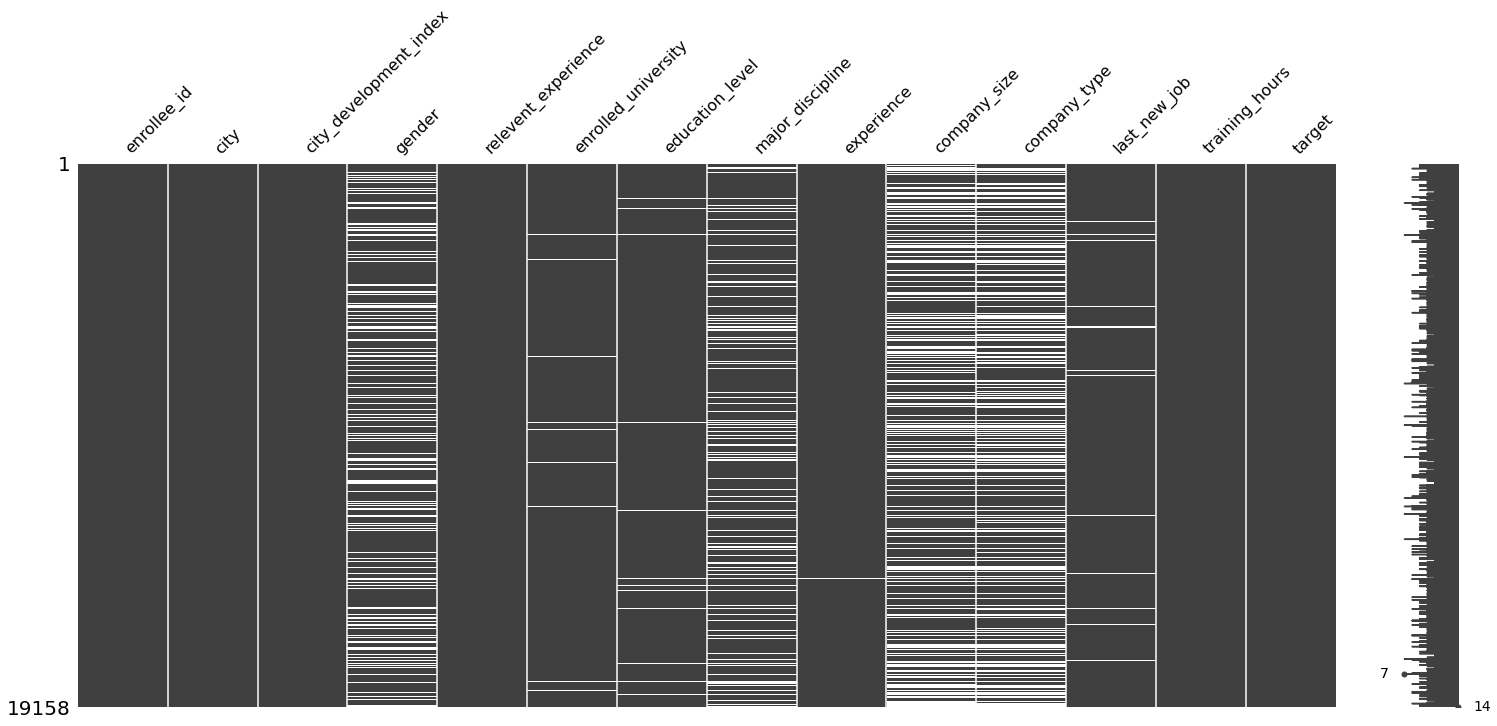

In [6]:
# Inspect missing values
msno.matrix(df)

plt.savefig('MissingValueMatrix.jpg',dpi=300, bbox_inches = 'tight');

Most missing values seem to come from 4 features: company_type, company_size, gender, and major_discipline 

Because of the amount of missing columns, we will attempt a couple of methods to working with the missing data.

1. Use a Sklearn's SimpleImputer and replace missing values with 'most frequent'
2. Create an entirely new category called 'missing'

We will use these two methods for our pipeline.

Before imputing data, perform initial exploratory analysis.

# Exploratory data analysis

In [7]:
# Observe target distribution
pd.DataFrame(df.target.value_counts()).reset_index()

,index,target
0,0,14381
1,1,4777


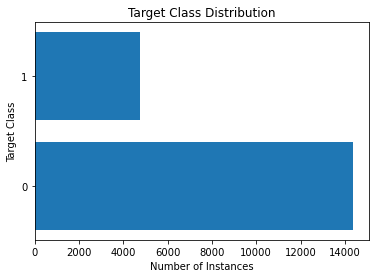

In [8]:
# Plot target distribution
plot_target_bar = pd.DataFrame(df.target.value_counts()).reset_index()
x, y = plot_target_bar['index'].astype(str), plot_target_bar['target']
plt.ylabel('Target Class')
plt.xlabel('Number of Instances')
plt.title('Target Class Distribution')
plt.barh(x,y)

plt.savefig('TargetDistribution.jpg',dpi=300, bbox_inches = 'tight');

As we can see, there is large imbalance between our target variables with our 0 class making up as much as 75% of the total number of instances in the dataset. Therefore, when evaluating our models, we need to not only include accuracy as a metric, but also precision and recall.

In [9]:
# Peek data
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0


## Observe for Skewed Data

In [10]:
num_feats = df.dtypes[ df.dtypes!='object' ].index
skew_feats = df[num_feats].skew().sort_values(ascending=False)
skewness=pd.DataFrame({'Skew':skew_feats})
skewness

,Skew
training_hours,1.819237
target,1.158815
enrollee_id,-0.018391
city_development_index,-0.995428


We will pay attention specifically to training_hours and city_development_index.

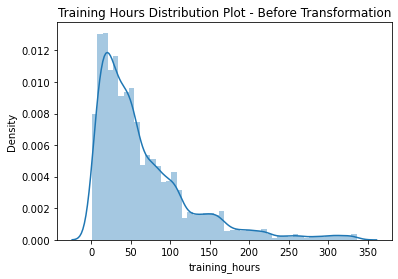

In [11]:
training_hours = df['training_hours']
sns.distplot(training_hours)
plt.title('Training Hours Distribution Plot - Before Transformation')

plt.savefig('TrainingHours_BeforeTransformation.jpg',dpi=300, bbox_inches = 'tight');

There is an apparent right skew in training hours that we should address for our model. Let's observe how applying a log transformation could make the distribution more gaussian.

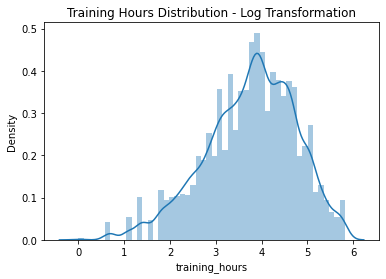

In [12]:
log_training_hours = np.log(df['training_hours'])
sns.distplot(log_training_hours)
plt.title('Training Hours Distribution - Log Transformation')

plt.savefig('TrainingHours_AfterTransformation.jpg',dpi=300, bbox_inches = 'tight');

Applying a log transformation towards the training hours column appears to make the distribution more gaussian and suitable for modeling purposes.

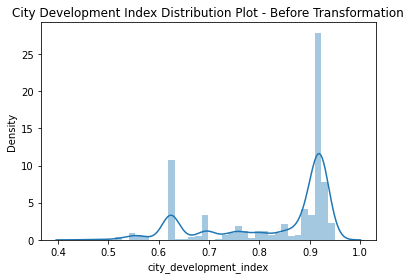

In [13]:
city_dev_index = df['city_development_index']
sns.distplot(city_dev_index)
plt.title('City Development Index Distribution Plot - Before Transformation')

plt.savefig('CityDevIndex_BeforeTransformation.jpg',dpi=300, bbox_inches = 'tight');

There appears to be a bimodal peaks with a left skew on the city_development_index column. Let's aim to apply a few transformation to address this in our pipeline.

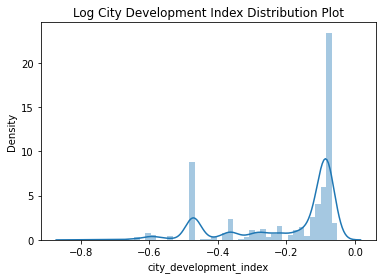

In [14]:
log_city_dev_index = np.log(df['city_development_index'])
sns.distplot(log_city_dev_index)
plt.title('Log City Development Index Distribution Plot');

The log transformation on the city_development_index column appeared to not have a major impact to making the distribution more gaussian. We will aim other transformation methods

In [15]:
power = PowerTransformer(method='yeo-johnson', standardize=True)
pwr_city_dev = power.fit_transform( df[['city_development_index']] )

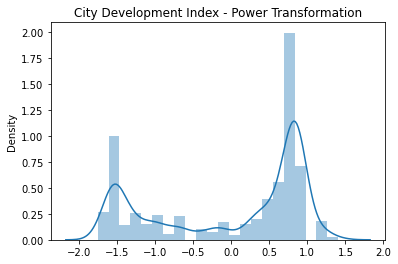

In [16]:
sns.distplot(pwr_city_dev)
plt.title('City Development Index - Power Transformation')

plt.savefig('CityDevIndex_AfterTransformation.jpg',dpi=300, bbox_inches = 'tight');

A power transformation appears to work better in making the distribution more gaussian. The bimodal peak is still apparent.

In [17]:
# Check for any apparent correlations -- specifically around city_development_index and training_hours
df[[x for x in df.columns if x != 'enrollee_id']].corr()

,city_development_index,training_hours,target
city_development_index,1.000000,0.001920,-0.341665
training_hours,0.001920,1.000000,-0.021577
target,-0.341665,-0.021577,1.000000


We are able to observe there is no significant correlation between the numeric variables and our target. The feature with the highest correlation is city_development_index.

We observe an imbalance with our target. The imbalance is something we should address using stratified Kfold

In [18]:
# Drop gender column to prevent against gender bias
df.drop(['enrollee_id','gender'],axis=1,inplace=True)

df.head()

,city,city_development_index,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,city_103,0.920,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1
1,city_40,0.776,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0
2,city_21,0.624,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0
3,city_115,0.789,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1
4,city_162,0.767,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0


Since the majority of the columns in the data are categorical, let us organize the columns into nominal and ordinal types to encode them appropriately.

# Set Categorical Encoding

In [19]:
# Access the columns of type object 
df.loc[:, df.dtypes == object].head()

,city,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job
0,city_103,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1
1,city_40,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4
2,city_21,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never
3,city_115,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never
4,city_162,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4


In [20]:
# Separate the columns into nominal and ordinal type columns
nominal = ['city', 'relevent_experience','enrolled_university','major_discipline','company_type']
ordinal = ['education_level','experience','company_size','last_new_job']

## Ordinal Encode Mapping

Set mapping and ordering required for Sklearn's OrdinalEncoder to use in pipeline

### Education Level

In [21]:
# Peek at unique values of education_level and order them to feed into sklearn's OrdinalEncoder
df.education_level.unique()

array(['Graduate', 'Masters', 'High School', nan, 'Phd', 'Primary School'],
      dtype=object)

In [22]:
# Set the ordering for education level
edu_level_ord = [['missing','Primary School', 'High School', 'Graduate', 'Masters', 'Phd']]

### Experience 

In [23]:
# Peek at unique values of experience and order them to feed into sklearn's OrdinalEncoder
df.experience.unique()

array(['>20', '15', '5', '<1', '11', '13', '7', '17', '2', '16', '1', '4',
       '10', '14', '18', '19', '12', '3', '6', '9', '8', '20', nan],
      dtype=object)

In [24]:
# Assuming we replace missing values with the string 'missing'
experience_ord = [['missing', 
                   '<1', 
                   '1', 
                   '2', 
                   '3', 
                   '4', 
                   '5', 
                   '6', 
                   '7', 
                   '8', 
                   '9', 
                   '10', 
                   '11', 
                   '12', 
                   '13', 
                   '14', 
                   '15', 
                   '16', 
                   '17', 
                   '18', 
                   '19', 
                   '20', 
                   '>20']]

### Company Size

In [25]:
df.company_size.unique()

array([nan, '50-99', '<10', '10000+', '5000-9999', '1000-4999', '10/49',
       '100-500', '500-999'], dtype=object)

In [26]:
# Assuming we replace missing values with the string 'missing'
company_size_ord = [['missing', 
                   '<10', 
                   '10/49', 
                   '50-99', 
                   '100-500', 
                   '500-999', 
                   '1000-4999', 
                   '5000-9999', 
                   '10000+']]

### Last New Job

In [27]:
df.last_new_job.unique()

array(['1', '>4', 'never', '4', '3', '2', nan], dtype=object)

In [28]:
# Assuming we replace missing values with the string 'missing'
last_new_job_ord = [['missing', 
                   'never', 
                   '1', 
                   '2', 
                   '3', 
                   '4', 
                   '>4']]

# Set up simple model using Logistic Regression

We will test our simple model against three dataframes using three different methods of imputation: 

- Dropping missing values
- 'missing' value (create a new category called 'missing') imputation dataframe
- 'most frequent' value imputation

After setting up our three sets of data to run our simple LogisticRegression model we will perform the following:
1. Split data
2. Apply transformations
3. Train logistic regression model

Now we've created two dataframes with two different types of imputation methods. We will test both and observe which performs better on a baseline model.

## Missing as a new category - Train Test Split

In [29]:
df_baseline = df.copy()

# Create a df where missing values are filled with 'missing', and as a result craeting a new category
df_missing_baseline = df_baseline.fillna('missing')
# Separate target and predictors

# 'missing' new value imputation
y_missing = df_missing_baseline.target
X_missing = df_missing_baseline.drop('target',axis=1)

In [30]:
# Separate into train and test

# 'missing' new value imputation
X_train_mis, X_test_mis, y_train_mis, y_test_mis = train_test_split(X_missing, y_missing, test_size=0.25)

## Most frequent imputation - Train Test Split

In [31]:
# Create a df where most_frequent is used as the strategy to address missing values

# Set up frequent_imputer
frequent_imputer = SimpleImputer(strategy='most_frequent')

# Create a copy of our original df called df_frequent_baseline to help us organize how we're separating our baselines
df_frequent_baseline = df.copy()

# Most frequent imputation
y_freq = df_frequent_baseline.target
X_freq = df_frequent_baseline.drop('target',axis=1)

In [32]:
# Separate into train and test

# Most frequent imputation
X_train_freq, X_test_freq, y_train_freq, y_test_freq = train_test_split(X_freq, y_freq, test_size=0.25)

## Drop missing values - Train Test Split

In [33]:
# Retain original dataframe and create a new one to drop null values
df_drop = df.copy()
df_drop.dropna(inplace=True)

y_drop = df_drop.target
X_drop = df_drop.drop('target',axis=1)

# Create train test split from our dropped null values dataframe
X_train_drop, X_test_drop, y_train_drop, y_test_drop = train_test_split(X_drop, y_drop, test_size=0.25)

## Set up ColumnTransformer and pipeline

In [34]:
# Set up helper function for retrieving the index of a column given column name
def get_column_index(df, col_name):
    return df.columns.get_loc(col_name)

For mixed types of numeric, nominal, and ordinal features, use sklearn's ColumnTransformer.

For the two numeric columns we will use:
- Log Transform for Training Hours
- Power Transform for City Development Index

In [35]:
#For mixed types of numeric, nominal, and ordinal features, use sklearn's ColumnTransformer
log_transform = FunctionTransformer(np.log1p, validate=True)

t = [
    ("log_transform", FunctionTransformer(np.log1p, validate=True), [get_column_index(df_missing_baseline, 'training_hours')]),
    ("pwr_transform", PowerTransformer(method='yeo-johnson', standardize=True), [get_column_index(df_missing_baseline, 'city_development_index')]),
    ("nominal", OneHotEncoder(handle_unknown='ignore'), [get_column_index(df_missing_baseline, x) for x in nominal]),
    ("edu_ord", OrdinalEncoder(categories=edu_level_ord),[get_column_index(df_missing_baseline, 'education_level') ]),
    ("exp_ord", OrdinalEncoder(categories=experience_ord), [get_column_index(df_missing_baseline, 'experience') ]),
    ("comp_size_ord", OrdinalEncoder(categories=company_size_ord), [get_column_index(df_missing_baseline, 'company_size') ]),
    ("new_job_ord", OrdinalEncoder(categories=last_new_job_ord), [get_column_index(df_missing_baseline, 'last_new_job') ]),
    ]

## Run Simple Model

Run simple model against the three dataframes: 
- Dropping missing values
- 'missing' value (create a new category called 'missing') imputation dataframe
- 'most frequent' value imputation

In [36]:
# define model
lr_model = LogisticRegression(solver='liblinear')
# define transform
ct = ColumnTransformer(transformers=t)
# define pipeline
pipeline = Pipeline(steps=[('t', ct), ('m',lr_model)])
# fit the pipeline on the transformed data
pipeline.fit(X_train_drop, y_train_drop.astype('int'))
# make predictions
yhat_drop = pipeline.predict(X_test_drop)

In [37]:
# Check classification metrics
print(classification_report(y_test_drop, yhat_drop))

              precision    recall  f1-score   support

           0       0.91      0.92      0.92      2319
           1       0.60      0.55      0.58       476

    accuracy                           0.86      2795
   macro avg       0.75      0.74      0.75      2795
weighted avg       0.86      0.86      0.86      2795



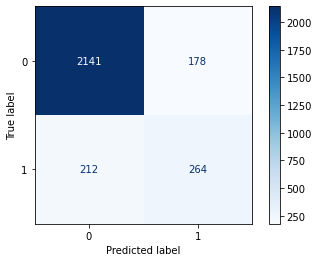

In [38]:
# Plot confusion matrix
plot_confusion_matrix(pipeline, X_test_drop, y_test_drop,
                     cmap=plt.cm.Blues);

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.739


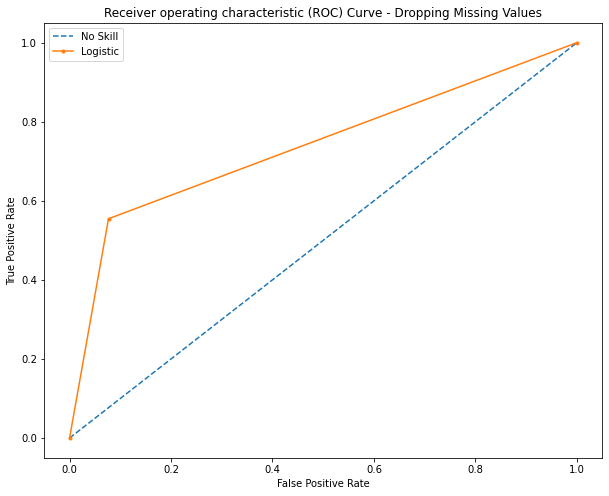

In [39]:
# Plot and examine ROC AUC Curve
fig, ax = plt.subplots(figsize=(10,8))

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test_drop))]

# calculate scores
ns_auc = roc_auc_score(y_test_drop, ns_probs)
lr_auc = roc_auc_score(y_test_drop, yhat_drop)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test_drop, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test_drop, yhat_drop)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title("Receiver operating characteristic (ROC) Curve - Dropping Missing Values")

# show the legend
plt.legend()

# Save fig
plt.savefig('LR_ROCCurve_drop.jpg',dpi=300, bbox_inches = 'tight');

Our simple logistic regression model against the dataframe with dropped missing values appears to perform decently with an AUC score of 0.7. However, let's continue with other methods of missing value imputation before moving forward.

### Missing Value Simple Model Evaluation

In [40]:
# define model
lr_model = LogisticRegression(solver='liblinear')
# define transform
ct = ColumnTransformer(transformers=t)
# define pipeline
pipeline = Pipeline(steps=[('t', ct), ('m',lr_model)])
# fit the pipeline on the transformed data
pipeline.fit(X_train_mis, y_train_mis.astype('int'))
# make predictions
yhat_mis = pipeline.predict(X_test_mis)

In [41]:
# Check classification metrics
print(classification_report(y_test_mis, yhat_mis))

              precision    recall  f1-score   support

           0       0.82      0.93      0.87      3621
           1       0.61      0.35      0.44      1169

    accuracy                           0.79      4790
   macro avg       0.71      0.64      0.66      4790
weighted avg       0.76      0.79      0.76      4790



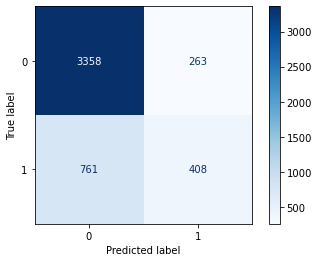

In [42]:
plot_confusion_matrix(pipeline, X_test_mis, y_test_mis,
                     cmap=plt.cm.Blues);

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.638


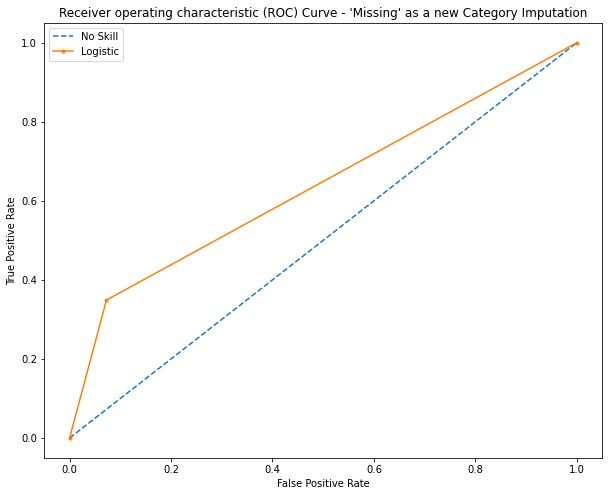

In [43]:
fig, ax = plt.subplots(figsize=(10,8))

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test_mis))]

# calculate scores
ns_auc = roc_auc_score(y_test_mis, ns_probs)
lr_auc = roc_auc_score(y_test_mis, yhat_mis)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test_mis, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test_mis, yhat_mis)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title("Receiver operating characteristic (ROC) Curve - 'Missing' as a new Category Imputation")

# show the legend
plt.legend()

# Save fig
plt.savefig('LR_ROCCurve_Missing.jpg',dpi=300, bbox_inches = 'tight');

Since 0 is our majority class making as much as 75% of our target class, it  makes sense that its f1-score is significantly higher than the 1 class. In contrast, the 1 class has a poor f1 score. Specifically with low recall score of 0.34, this is our model is having a hard time classifying participants that will work for the data science company, actually will work for the company conducting data science training.

### Most Frequent Imputation Simple Model Evaluation

In [44]:
t = [
    ("log_transform", FunctionTransformer(np.log1p, validate=True), [get_column_index(df_frequent_baseline, 'training_hours')]),
    ("pwr_transform", PowerTransformer(method='yeo-johnson', standardize=True), [get_column_index(df_frequent_baseline, 'city_development_index')]),
    ("nominal", OneHotEncoder(handle_unknown='ignore'), [get_column_index(df_frequent_baseline, x) for x in nominal]),
    ("edu_ord", OrdinalEncoder(categories=edu_level_ord),[get_column_index(df_frequent_baseline, 'education_level') ]),
    ("exp_ord", OrdinalEncoder(categories=experience_ord), [get_column_index(df_frequent_baseline, 'experience') ]),
    ("comp_size_ord", OrdinalEncoder(categories=company_size_ord), [get_column_index(df_frequent_baseline, 'company_size') ]),
    ("new_job_ord", OrdinalEncoder(categories=last_new_job_ord), [get_column_index(df_frequent_baseline, 'last_new_job') ]),
    ]

For our most frequent imputer imputation simple model evaluation, we want to set up a separate pipeline that includes the SimpleImputer object in a separate step. We need to include this as a separate step in the pipeline in order to prevent data leakage.

In the cell below, we will create a separate pipeline object called **pipeline_freq**

In [45]:
# define model
lr_model = LogisticRegression(solver='liblinear')
# define transform
ct = ColumnTransformer(transformers=t)
# define pipeline
pipeline_freq = Pipeline(steps=[('imp',frequent_imputer),('t', ct), ('m',lr_model)])
# fit the pipeline on the transformed data
pipeline_freq.fit(X_train_freq, y_train_freq.astype('int'))
# make predictions
yhat_freq = pipeline_freq.predict(X_test_freq)

In [46]:
# Check classification metrics
y_test_freq = y_test_freq.astype('int')

print(classification_report(y_test_freq, yhat_freq))

              precision    recall  f1-score   support

           0       0.81      0.92      0.86      3607
           1       0.58      0.34      0.43      1183

    accuracy                           0.78      4790
   macro avg       0.70      0.63      0.65      4790
weighted avg       0.75      0.78      0.76      4790



No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.631


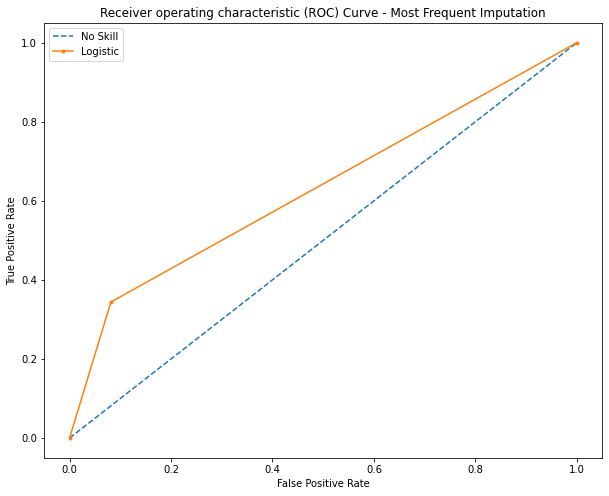

In [47]:
fig, ax = plt.subplots(figsize=(10,8))

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test_freq))]

# calculate scores
ns_auc = roc_auc_score(y_test_freq, ns_probs)
lr_auc = roc_auc_score(y_test_freq, yhat_freq)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test_freq, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test_freq, yhat_freq)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title("Receiver operating characteristic (ROC) Curve - Most Frequent Imputation")

# show the legend
plt.legend()

# Save fig
plt.savefig('LR_ROCCurve_Freq.jpg',dpi=300, bbox_inches = 'tight');

Both methods of imputation performed fairly similar both with the same accuracy of 77%. However, it appears the method simply dropping missing values appeared to perform best with an accuracy of 85% and an AUC score of 0.7.

Based on these initial results, we will move forward with simply dropping missing values.

Let's outline our next steps:
1. DecisionTreeClassifier
2. Extract feature importance from DecisionTreeClassifier
3. Experiment with RandomForest and XGBoost
4. Hyperparameter tuning

# Loop over simple models and move forward with the best one

In [48]:
# Encode our target to binary
y_drop = df_drop.target
X_drop = df_drop.drop('target',axis=1)

label_encoder = LabelEncoder()
y_drop = label_encoder.fit_transform(y_drop)

In [49]:
# Instantiate models to loop over
dt = DecisionTreeClassifier()
xgb_clf = xgb.XGBClassifier()
lr = LogisticRegression(solver='liblinear')
rf = RandomForestClassifier()
svc = SVC()

# Create model list to iterate over
# models = [lr, dt, rf, xgb]

models = {'Logistic Regression': lr,
          'Support Vector Machine': svc,
          'Decision Tree Classifier': dt,
          'Random Forest': rf,
          'XGBoost' :xgb_clf
         }

model_results = {'Model Name':[],
                 'Fold':[],
                 'Simple Model Accuracy Train':[],
                 'Simple Model Accuracy Test':[]
                }

# Instantiate Stratified KFold
skf = StratifiedKFold(n_splits=5)

k_fold = 0

for train_index, test_index in tqdm(skf.split(X_drop,y_drop)):
    X_train, X_test = X_drop.iloc[train_index], X_drop.iloc[test_index]
    y_train, y_test = y_drop[train_index], y_drop[test_index]
    k_fold += 1
    for model_label, model in models.items():
        ct = ColumnTransformer(transformers=t)
        # define pipeline
        pipeline = Pipeline(steps=[('t', ct), ('m',model)])
        # fit the pipeline on the transformed data
        pipeline.fit(X_train, y_train.astype('int'))
        # make predictions
        yhat_drop = pipeline.predict(X_test)
        yhat_train_drop = pipeline.predict(X_train)
        # Calculate accuracy score
        score_train = accuracy_score(y_train, yhat_train_drop)
        score_train = round(score_train, 2)*100
        score_test = accuracy_score(y_test, yhat_drop)
        score_test = round(score_test, 2)*100
        # Append results
        model_results['Model Name'].append(model_label)
        model_results['Fold'].append(k_fold)
        model_results['Simple Model Accuracy Train'].append(score_train)
        model_results['Simple Model Accuracy Test'].append(score_test)

0it [00:00, ?it/s]

[20:24:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


1it [00:11, 11.29s/it]

[20:24:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2it [00:22, 11.34s/it]

[20:24:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


3it [00:34, 11.43s/it]

[20:24:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


4it [00:45, 11.39s/it]

[20:24:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


5it [00:56, 11.29s/it]


In [50]:
# Prepare and aggregate the accuracy scores from the model runs on the kfolds
results_df = pd.DataFrame( model_results )

results_agg_df = results_df.groupby('Model Name')[['Simple Model Accuracy Train', 'Simple Model Accuracy Test']].mean().reset_index()

results_agg_df

,Model Name,Simple Model Accuracy Train,Simple Model Accuracy Test
0,Decision Tree Classifier,100.0,77.4
1,Logistic Regression,85.0,85.0
2,Random Forest,100.0,84.0
3,Support Vector Machine,84.6,84.6
4,XGBoost,90.4,84.2


# Simple model candidate results

In [51]:
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                '%d' % int(height),
                ha='center', va='bottom')
        

Code above is modified and borrowed from https://stackoverflow.com/questions/45177937/how-can-i-adapt-the-autolabel-function-in-matplotlib-so-that-it-displays-negativ

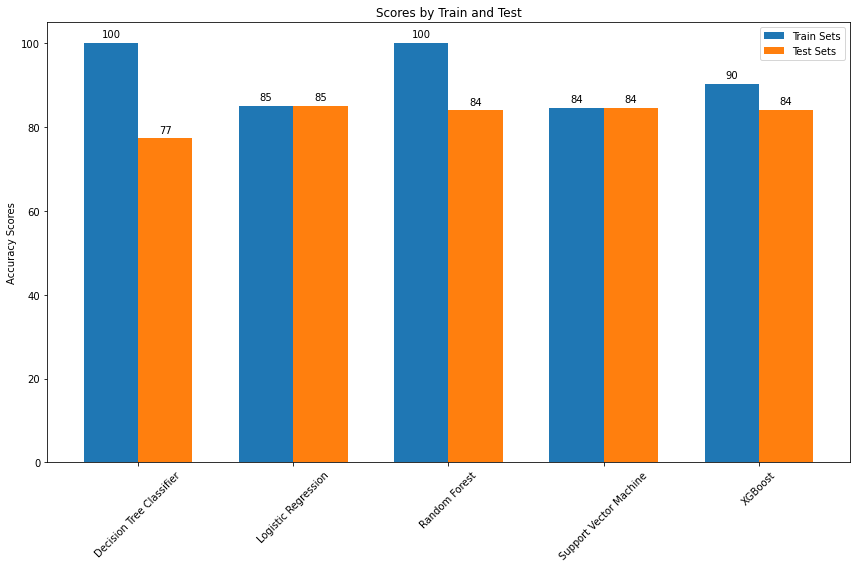

In [52]:
labels = results_agg_df['Model Name']
train_means = results_agg_df['Simple Model Accuracy Train']
test_means = results_agg_df['Simple Model Accuracy Test']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12,8))
rects1 = ax.bar(x - width/2, train_means, width, label='Train Sets')
rects2 = ax.bar(x + width/2, test_means, width, label='Test Sets')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy Scores')
ax.set_title('Scores by Train and Test')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

autolabel(rects1)
autolabel(rects2)

plt.xticks(rotation=45)

fig.tight_layout()

plt.savefig('ScoresbyTrainandTest.jpg',dpi=300, bbox_inches = 'tight')

Notably, there are signs of overfitting occurring within our DecisionTree, SVM, and XGBoost simple models given the higher train set accuracy scores. Nonetheless, it appears Logistic Regression has the highest average test accuracy score and so this is likely the model we want to move forward with and with an optimize.

Moreover, given the popularity, and popular hyperparameter optimization packages available for XGBoost, this is also a model I would like to test and move forward with despite the slight overfitting observed.

In terms of optimization, we will attempt the following:
- Extract feature importance from our more interpretable model -- Decision Tree Classifier
- Use Grid Search to find the optimal parameters for our SVM model
- Use the popular Optuna hyperparameter optimization library to improve our XGBoost simple model.

# Feature Importance

In [53]:
#For mixed types of numeric, nominal, and ordinal features, use sklearn's ColumnTransformer
log_transform = FunctionTransformer(np.log1p, validate=True)

t2 = [
    ("log_transform", FunctionTransformer(np.log1p, validate=True), [get_column_index(df_drop, 'training_hours')]),
    ("pwr_transform", PowerTransformer(method='yeo-johnson', standardize=True), [get_column_index(df_drop, 'city_development_index')]),
    ("edu_ord", OrdinalEncoder(categories=edu_level_ord),[get_column_index(df_drop, 'education_level') ]),
    ("exp_ord", OrdinalEncoder(categories=experience_ord), [get_column_index(df_drop, 'experience') ]),
    ("comp_size_ord", OrdinalEncoder(categories=company_size_ord), [get_column_index(df_drop, 'company_size') ]),
    ("new_job_ord", OrdinalEncoder(categories=last_new_job_ord), [get_column_index(df_drop, 'last_new_job') ]),
    ]

# Columns transformed = ['training_hours', 'city_development_index','education_level','experience','company_size','last_new_job']

In [54]:
# Encode our target to binary
y_drop = df_drop.target
X_drop = df_drop.drop('target',axis=1)

label_encoder = LabelEncoder()
y_drop = label_encoder.fit_transform(y_drop)

In [55]:
ct2 = ColumnTransformer(transformers=t2)
X_drop_t = ct2.fit_transform(X_drop)

In [56]:
# Separate the numeric features of our dataset
cols = ['training_hours', 'city_development_index','education_level','experience','company_size','last_new_job']
X_drop_t = pd.DataFrame(X_drop_t,columns = cols)

X_drop_t.head()

,training_hours,city_development_index,education_level,experience,company_size,last_new_job
0,3.871201,-0.993870,3.0,16.0,3.0,6.0
1,2.197225,-1.052303,4.0,22.0,3.0,5.0
2,2.944439,-1.082999,3.0,14.0,1.0,6.0
3,3.850148,0.782225,3.0,8.0,3.0,2.0
4,4.820282,0.782225,3.0,18.0,8.0,6.0


In [57]:
# Use pd.get_dummies to encode our nominal category columns
major_discipline_dummies = pd.get_dummies(X_drop.major_discipline)
major_discipline_dummies.columns = ["major_discipl_{}".format(i) for i in major_discipline_dummies.columns]

company_type_dummies = pd.get_dummies(X_drop.company_type)
company_type_dummies.columns = ["company_type_{}".format(i) for i in company_type_dummies.columns]

# Concat the encoding of our major discipline and company type features
X_drop_dummies = pd.concat([major_discipline_dummies, company_type_dummies], axis=1)

In [58]:
# Concatenate transformed columns
X_drop_fin = pd.concat([X_drop_t.reset_index(drop=True), X_drop_dummies.reset_index(drop=True)], axis=1 )
X_drop_fin.fillna(0,inplace=True)
print(X_drop_fin.shape)
X_drop_fin.head()

(11179, 18)


,training_hours,city_development_index,education_level,experience,company_size,last_new_job,major_discipl_Arts,major_discipl_Business Degree,major_discipl_Humanities,major_discipl_No Major,major_discipl_Other,major_discipl_STEM,company_type_Early Stage Startup,company_type_Funded Startup,company_type_NGO,company_type_Other,company_type_Public Sector,company_type_Pvt Ltd
0,3.871201,-0.993870,3.0,16.0,3.0,6.0,0,0,0,0,0,1,0,0,0,0,0,1
1,2.197225,-1.052303,4.0,22.0,3.0,5.0,0,0,0,0,0,1,0,1,0,0,0,0
2,2.944439,-1.082999,3.0,14.0,1.0,6.0,0,0,0,0,0,1,0,0,0,0,0,1
3,3.850148,0.782225,3.0,8.0,3.0,2.0,0,0,0,0,0,1,0,0,0,0,0,1
4,4.820282,0.782225,3.0,18.0,8.0,6.0,0,0,0,0,0,1,0,0,0,0,0,1


In [59]:
# Instantiate and fit DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(X_drop_fin, y_drop)

DecisionTreeClassifier()

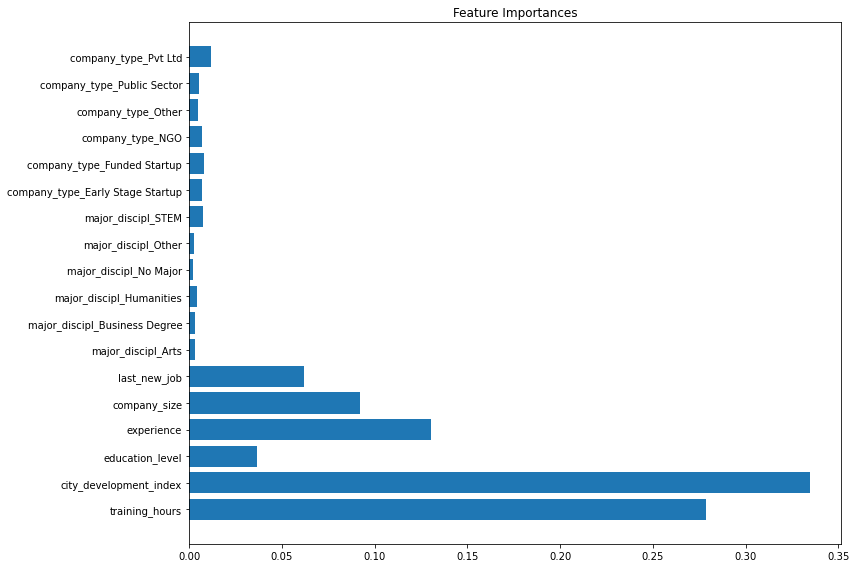

In [60]:
# Plot feature importances.
fig, ax = plt.subplots(figsize=(12,8))
ax.barh(X_drop_fin.columns, dt.feature_importances_, color='tab:blue')
ax.set(title='Feature Importances')
fig.tight_layout()

plt.savefig('FeatureImportances.jpg',dpi=300, bbox_inches = 'tight')

In order to get a better sense of the features that have a higher relevance in determining whether a participant will work for the data science training company or look for a new job, we used a simple DecisionTreeClassifier and extracted its determined feature importances.

As a result, we are able to observe that the city development index of the city where the participant is from plays the most important role in determining whether they will look for a new job or not. In descending order, the top 6 features include: 

1. City Development Index (from where the participant is from)
2. Training Hours Completed
3. Years of Experience
4. Current Company Size
5. Difference in years between previous job and current job
6. Highest Level of Education

# Hyperparameter Tuning - Logistic Regression

In [61]:
# Encode our target to binary
y_drop = df_drop.target
X_drop = df_drop.drop('target',axis=1)

relevent_features = ['training_hours','city_development_index','education_level','experience','company_size','last_new_job']
X_drop = X_drop[relevent_features]

label_encoder = LabelEncoder()
y_drop = label_encoder.fit_transform(y_drop)

In [62]:
# Most dropuent imputation and train test split
X_train_drop, X_test_drop, y_train_drop, y_test_drop = train_test_split(X_drop, y_drop, test_size=0.33)

In [63]:
# Set up modified transformer for the relevant features selected from previous step
t3 = [
    ("log_transform", FunctionTransformer(np.log1p, validate=True), [get_column_index(X_train_drop, 'training_hours')]),
    ("pwr_transform", PowerTransformer(method='yeo-johnson', standardize=True), [get_column_index(X_train_drop, 'city_development_index')]),
    ("edu_ord", OrdinalEncoder(categories=edu_level_ord),[get_column_index(X_train_drop, 'education_level') ]),
    ("exp_ord", OrdinalEncoder(categories=experience_ord), [get_column_index(X_train_drop, 'experience') ]),
    ("comp_size_ord", OrdinalEncoder(categories=company_size_ord), [get_column_index(X_train_drop, 'company_size') ]),
    ("new_job_ord", OrdinalEncoder(categories=last_new_job_ord), [get_column_index(X_train_drop, 'last_new_job') ]),
    ]

In [64]:
# Reuse previously created ColumnTransformer and Pipeline
ct = ColumnTransformer(transformers=t3)

# Instantiate our SVM
lr = LogisticRegression()

X_train_drop = ct.fit_transform(X_train_drop)

In [65]:
# # defining parameter range
kfolds = StratifiedKFold(3)

param_grid = { 'solver': ['newton-cg', 'lbfgs', 'liblinear'],
               'penalty' : ['l1', 'l2'],
               'C' : [100, 10, 1.0, 0.1, 0.01] }
  
grid = GridSearchCV(lr, param_grid, refit = True, cv=kfolds.split(X_train_drop,y_train_drop))
  
# fitting the model for grid search
grid.fit(X_train_drop, y_train_drop)

GridSearchCV(cv=<generator object _BaseKFold.split at 0x000001AF84EFCBA0>,
             estimator=LogisticRegression(),
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01],
                         'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']})

In [66]:
# Examine best params
print(f'Best Params: {grid.best_params_}')

Best Params: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}


In [67]:
# Set up new LR model using grid.best_params_
lr_best = LogisticRegression(**grid.best_params_)

In [68]:
# Fit the best params derived from the grid search towards the train set
lr_best.fit(X_train_drop, y_train_drop)

# Perform ColumnTransformer on Test set
X_test_drop = ct.fit_transform(X_test_drop)

# Perform predictions using best params from GridSearch
yhat_lr_best = lr_best.predict(X_test_drop)

print(classification_report(y_test_drop, yhat_lr_best))

              precision    recall  f1-score   support

           0       0.84      0.98      0.90      3043
           1       0.57      0.14      0.23       647

    accuracy                           0.83      3690
   macro avg       0.71      0.56      0.57      3690
weighted avg       0.79      0.83      0.79      3690



## Plot ROC AUC Curve - LR with Hyperparameter Tuning

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.560


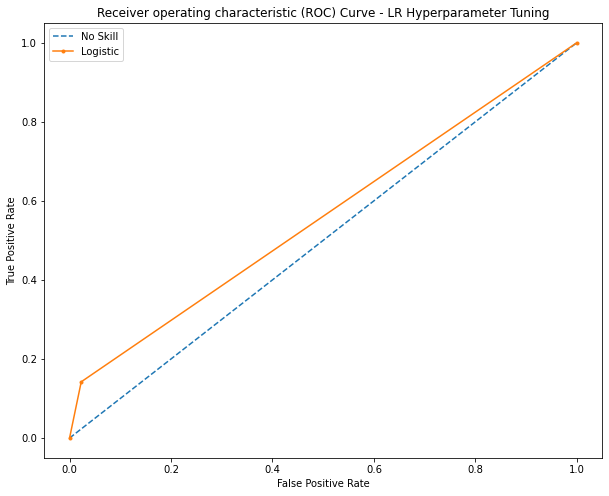

In [69]:
fig, ax = plt.subplots(figsize=(10,8))

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test_drop))]

# calculate scores
ns_auc = roc_auc_score(y_test_drop, ns_probs)
lr_auc = roc_auc_score(y_test_drop, yhat_lr_best)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test_drop, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test_drop, yhat_lr_best)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title("Receiver operating characteristic (ROC) Curve - LR Hyperparameter Tuning")

# show the legend
plt.legend()

# Save fig
plt.savefig('LRFinal_ROCCurve_drop.jpg',dpi=300, bbox_inches = 'tight');

It appears that there is a slight drop in accuracy from our simple logistic regression model to our hypertuned model (85% --> 83% ). Moreover, the true positive rate is still quite low, hovering slightly less than 0.2. 

It is worth noting that while the model is performing well in predicting whether a person will work for the company (class 0), the model still struggles in understanding whether a person will look for a new job, and so it is still not very informative in telling the company whether a person will look for a new job (class 1), and hence hamper the company's ability to adjust to the characteristics and the course for folks looking to leave their job.

# Hyperparameter Tuning - XGBoost

Code below is modified and borrowed from optuna.org

In [70]:
def objective(trial):
    y_drop = df_drop.target
    X_drop = df_drop.drop('target',axis=1)
    
    label_encoder = LabelEncoder()
    y_drop = label_encoder.fit_transform(y_drop)
    
    skf = StratifiedKFold(n_splits=5)

    scores = []
    
    for train_index, test_index in skf.split(X_drop,y_drop):
        train_x, test_x = X_drop.iloc[train_index], X_drop.iloc[test_index]
        train_y, test_y = y_drop[train_index], y_drop[test_index]

        ct = ColumnTransformer(transformers=t2)

        train_x = ct.fit_transform(train_x)
        test_x = ct.fit_transform(test_x)

        dtrain = xgb.DMatrix(train_x, label=train_y, enable_categorical=True)
        dtest = xgb.DMatrix(test_x, label=test_y, enable_categorical=True)

        param = {
#             "silent": 1,
            "objective": "binary:logistic",
            "eval_metric": "auc",
            "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
            "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
            "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
        }

        if param["booster"] == "gbtree" or param["booster"] == "dart":
            param["max_depth"] = trial.suggest_int("max_depth", 1, 9)
            param["eta"] = trial.suggest_loguniform("eta", 1e-8, 1.0)
            param["gamma"] = trial.suggest_loguniform("gamma", 1e-8, 1.0)
            param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
        if param["booster"] == "dart":
            param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
            param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
            param["rate_drop"] = trial.suggest_loguniform("rate_drop", 1e-8, 1.0)
            param["skip_drop"] = trial.suggest_loguniform("skip_drop", 1e-8, 1.0)

        bst = xgb.train(param, dtrain)
        preds = bst.predict(dtest)
        pred_labels = np.rint(preds)
        accuracy = accuracy_score(test_y, pred_labels)
        
        scores.append(accuracy)
    return np.mean(scores)

In [71]:
# Suppress log statements
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Run hyperparameter tuning study with optuna
study = optuna.create_study()
study.optimize(objective, n_trials=100, show_progress_bar=True)

In [72]:
# Print best params
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

    booster: dart
    lambda: 6.25424868754657e-08
    alpha: 0.3378532035423785
    max_depth: 8
    eta: 1.0845380910357793e-08
    gamma: 0.0032795800919795575
    grow_policy: depthwise
    sample_type: uniform
    normalize_type: forest
    rate_drop: 2.5922928219214717e-05
    skip_drop: 6.542375917105823e-07


In [87]:
# Based on best params from optuna hyperparameter tuning, use the best params
params = {
    'booster': 'dart',
    'lambda': 6.25424868754657e-08,
    'alpha': 0.3378532035423785,
    'max_depth': 8,
    'eta': 1.0845380910357793e-08,
    'gamma': 0.0032795800919795575,
    'grow_policy': 'depthwise',
    'sample_type': 'uniform',
    'normalize_type': 'forest',
    'rate_drop': 2.5922928219214717e-05,
    'skip_drop': 6.542375917105823e-07
     }

xgb_clf_fin = xgb.XGBClassifier(params=params)

In [88]:
hist = study.trials_dataframe()
hist.head()

,number,value,datetime_start,datetime_complete,duration,params_alpha,params_booster,params_eta,params_gamma,params_grow_policy,params_lambda,params_max_depth,params_normalize_type,params_rate_drop,params_sample_type,params_skip_drop,state
0,0,0.832455,2021-07-15 20:24:54.415039,2021-07-15 20:24:55.128653,0 days 00:00:00.713614,9.805686e-05,gbtree,0.169605,1.133916e-03,lossguide,7.051081e-07,3.0,NaN,NaN,NaN,NaN,COMPLETE
1,1,0.833886,2021-07-15 20:24:55.131642,2021-07-15 20:24:55.812364,0 days 00:00:00.680722,1.468879e-08,dart,0.001029,1.366503e-02,depthwise,5.448551e-07,5.0,forest,1.628754e-01,uniform,0.000040,COMPLETE
2,2,0.833886,2021-07-15 20:24:55.815357,2021-07-15 20:24:56.481579,0 days 00:00:00.666222,1.257218e-08,gbtree,0.000143,1.328236e-06,lossguide,9.187705e-03,5.0,NaN,NaN,NaN,NaN,COMPLETE
3,3,0.829323,2021-07-15 20:24:56.483572,2021-07-15 20:24:57.250641,0 days 00:00:00.767069,5.169953e-02,dart,0.000887,4.527374e-07,depthwise,1.266738e-02,7.0,forest,8.627321e-08,uniform,0.000047,COMPLETE
4,4,0.833259,2021-07-15 20:24:57.253631,2021-07-15 20:24:57.961353,0 days 00:00:00.707722,3.229605e-02,gbtree,0.027360,2.583721e-01,lossguide,1.473528e-05,7.0,NaN,NaN,NaN,NaN,COMPLETE


In [89]:
visualization.plot_optimization_history(study)

The plot above showcases the AUC score (y-axis) over the number of trials performed (x-axis). Through the 100 trials performed during hyperparameter tuning, it was observed that at trial 5, we received our highest AUC score of 0.834. From Optuna, we are able to pull the best params and perform final modeling. 

# Final Model with XGBoost Best Params

## Set up Train Sample

In [77]:
# Set up training
y = df_drop.target
X = df_drop.drop('target',axis=1)

# Encode target
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Train test split
# Use stratify parameter to preserve the target label proportions found in the original dataset 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

# Set Transformers
t_train = [
    ("log_transform", FunctionTransformer(np.log1p, validate=True), [get_column_index(X, 'training_hours')]),
    ("pwr_transform", PowerTransformer(method='yeo-johnson', standardize=True), [get_column_index(X, 'city_development_index')]),
    ("nominal", OneHotEncoder(handle_unknown='ignore'), [get_column_index(X, x) for x in nominal]),
    ("edu_ord", OrdinalEncoder(categories=edu_level_ord),[get_column_index(X, 'education_level') ]),
    ("exp_ord", OrdinalEncoder(categories=experience_ord), [get_column_index(X, 'experience') ]),
    ("comp_size_ord", OrdinalEncoder(categories=company_size_ord), [get_column_index(X, 'company_size') ]),
    ("new_job_ord", OrdinalEncoder(categories=last_new_job_ord), [get_column_index(X, 'last_new_job') ]),
    ]

# Transform features
ct_train = ColumnTransformer(transformers=t_train)

# define pipeline
pipeline = Pipeline(steps=[('t', ct_train), ('m', xgb_clf_fin)])

# fit the pipeline on the transformed data
pipeline.fit(X_train, y_train)

[20:25:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:25:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('t',
                 ColumnTransformer(transformers=[('log_transform',
                                                  FunctionTransformer(func=<ufunc 'log1p'>,
                                                                      validate=True),
                                                  [10]),
                                                 ('pwr_transform',
                                                  PowerTransformer(), [1]),
                                                 ('nominal',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  [0, 2, 3, 5, 8]),
                                                 ('edu_ord',
                                                  OrdinalEncoder(categories=[['missing',
                                                                              'Primary '
                                                                           

## Predict on Test

In [78]:
preds = pipeline.predict(X_test)

In [79]:
# Check classification metrics
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90      2293
           1       0.56      0.39      0.46       502

    accuracy                           0.84      2795
   macro avg       0.72      0.66      0.68      2795
weighted avg       0.82      0.84      0.82      2795



## Plot ROC AUC Curve - XGB with Hyperparameter Tuning

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.663


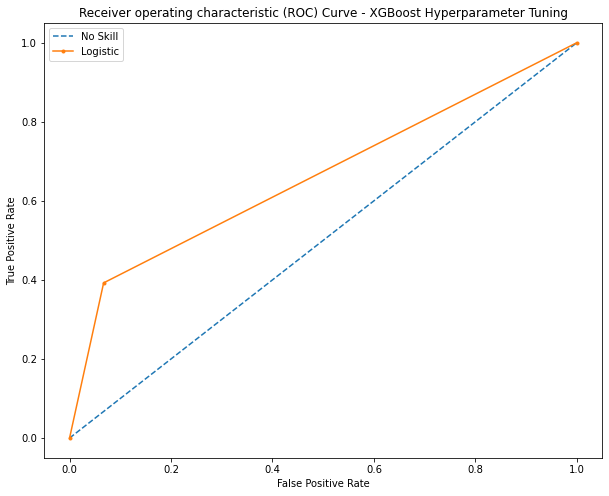

In [80]:
fig, ax = plt.subplots(figsize=(10,8))

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
xgb_auc = roc_auc_score(y_test, preds)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (xgb_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, preds)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(xgb_fpr, xgb_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title("Receiver operating characteristic (ROC) Curve - XGBoost Hyperparameter Tuning")

# show the legend
plt.legend()

# Save fig
plt.savefig('XGBFinal_ROCCurve_drop.jpg',dpi=300, bbox_inches = 'tight');

The tuned XGboost model performs much better than our tuned LR model (0.678 compared to 0.558). Therefore for future iterations of the model, we may wish to continue with XGBoost.

However, it is still worth noting that the model performance on predicting whether a person will leave the company (class 1) is poor with an f1-score of 0.49 compared to class 0's f1-score of 0.9. In order to improve this outcome, we will need more instances of class 1 to train against, and hence better understand the factor that lead a person to leave their job after data science training. 

# Characteristics of People Looking for a new Job

## City Development Index Comparison

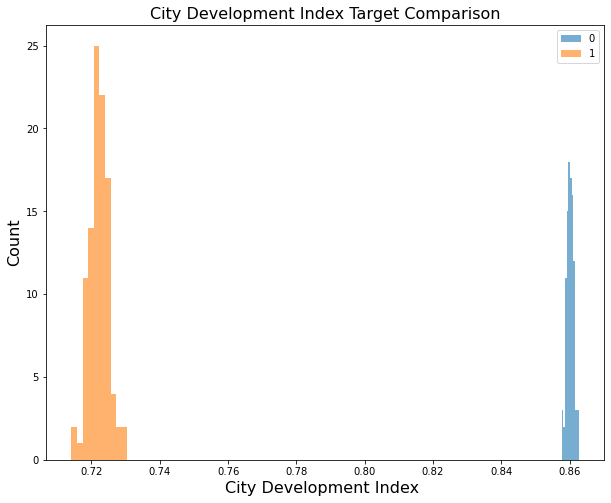

In [81]:
fig, ax = plt.subplots(figsize=(10,8))

# Iterate through target label
for t in df_drop.target.unique():
    # Create temp dataframe for the genre being iterated on
    frame = df_drop[df_drop.target==t]
    
    # Create list of sample_means of size 100 to plot distributions of averagerating.
    # Set up city dev index comparison
    sample_means = [np.random.choice(frame.city_development_index, replace=True, size=len(frame)).mean() for x in range(100)]
    plt.hist(sample_means, label=t,alpha=0.6)
    
plt.legend()
plt.ylabel('Count',fontsize=16)
plt.xlabel('City Development Index ',fontsize=16)
plt.title('City Development Index Target Comparison',fontsize=16)

# Format and save fig
plt.savefig('CityDevelopmentComparison.jpg',dpi=300, bbox_inches = 'tight')

In the visual above, I bootstrapped the target variables to generate a distribution over each targets' city development index to provide a comparison of how city development index plays as a factor for whether a person looks for a new job or not after completing data science training. We can observe that people who are not look for a job typically live in better developed cities compared to people in looking for jobs in lower developed cities.

## Training Hours Comparison

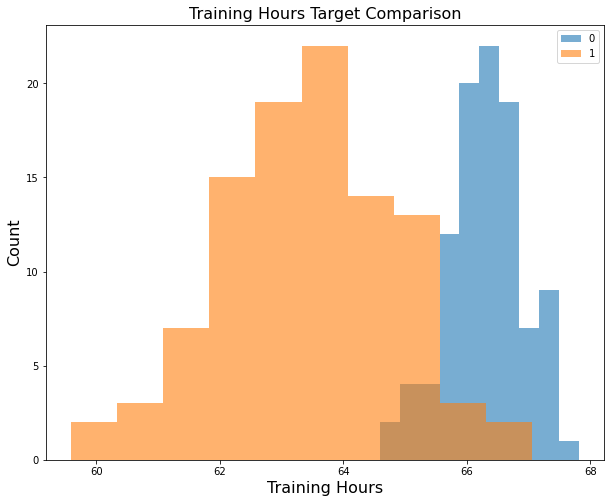

In [82]:
fig, ax = plt.subplots(figsize=(10,8))

# Iterate through target label
for t in df_drop.target.unique():
    # Create temp dataframe for the genre being iterated on
    frame = df_drop[df_drop.target==t]
    
    # Create list of sample_means of size 100 to plot distributions of averagerating.
    # Set up city dev index comparison
    sample_means = [np.random.choice(frame.training_hours, replace=True, size=len(frame)).mean() for x in range(100)]
    plt.hist(sample_means, label=t,alpha=0.6)
    
plt.legend()
plt.ylabel('Count',fontsize=16)
plt.xlabel('Training Hours',fontsize=16)
plt.title('Training Hours Target Comparison',fontsize=16)

# Format and save fig
plt.savefig('TrainingHours_Comparison.jpg',dpi=300, bbox_inches = 'tight')

In the visual above, I bootstrapped the target variables to generate a distribution over each targets' training hours to provide a comparison of how the number of training hours completed plays as a factor for whether a person looks for a new job or not after completing data science training. We can observe that people who are not looking for a new job typically spend more hours training versus people who are looking for a new job.

## Experience Comparison

In [83]:
# Collect 100 samples of the dataframe 100 times
plot_df = pd.DataFrame()
for i in tqdm(range(100)):
    experience_1_sample = df_drop[df_drop['target']==1].sample(n=1000,replace=True)
    experience_0_sample = df_drop[df_drop['target']==0].sample(n=1000,replace=True)
    
    append_0 = pd.DataFrame(experience_0_sample.groupby(['target','experience']).size()).reset_index().rename(columns={0:'Count'})
    append_1 = pd.DataFrame(experience_1_sample.groupby(['target','experience']).size()).reset_index().rename(columns={0:'Count'})
    
    plot_df = plot_df.append(append_0)
    plot_df = plot_df.append(append_1)

100%|██████████| 100/100 [00:01<00:00, 86.56it/s]


In [84]:
print(plot_df.shape)
plot_df.head()

(4397, 3)


,target,experience,Count
0,0,1,10
1,0,10,59
2,0,11,45
3,0,12,34
4,0,13,23


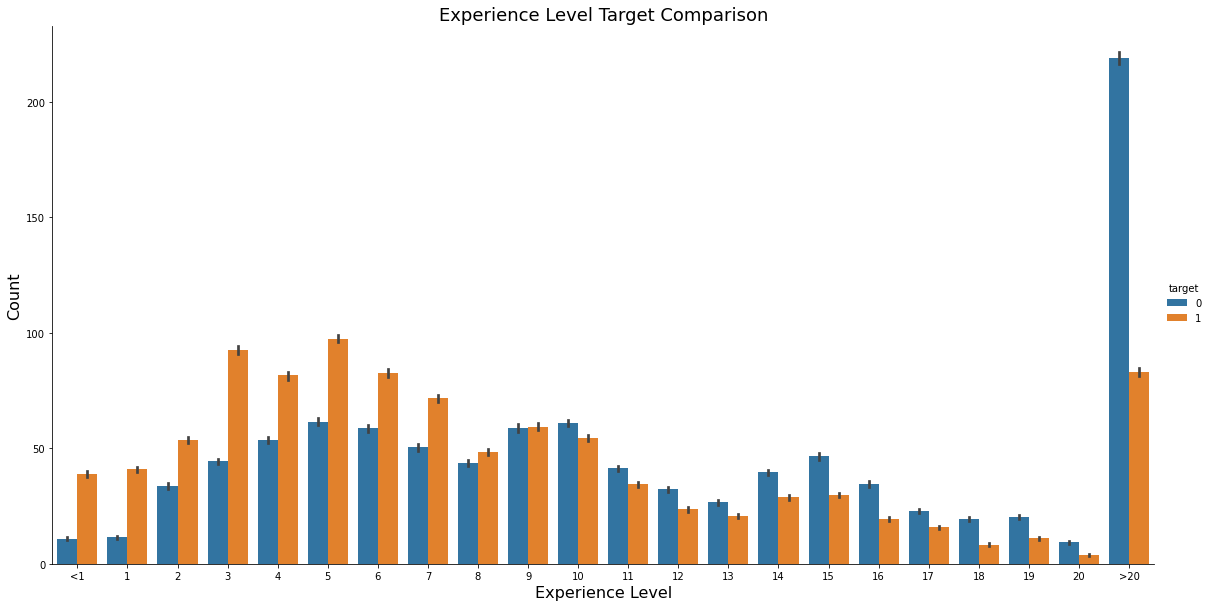

In [85]:
# Plot df
order = [ '<1', 
           '1', 
           '2', 
           '3', 
           '4', 
           '5', 
           '6', 
           '7', 
           '8', 
           '9', 
           '10', 
           '11', 
           '12', 
           '13', 
           '14', 
           '15', 
           '16', 
           '17', 
           '18', 
           '19', 
           '20', 
           '>20' ]

sns.catplot(x="experience", y="Count", hue="target", kind="bar", data=plot_df, order=order, height=8, aspect=2)
plt.xlabel('Experience Level',fontsize=16)
plt.ylabel('Count',fontsize=16)
plt.title('Experience Level Target Comparison',fontsize=18)

# Format and save fig
plt.savefig('ExperienceLevel_Comparison.jpg',dpi=300, bbox_inches = 'tight')

Lastly, through a similar bootstrapping method used in the above two visuals, I looked at how years of experience play as a factor for people looking for a new job or not. It appears that typically people with 9 years or less experience are more open to looking for new roles compared to people who have 10+ years of experience, where they are more likely to stay put in their current role. 

# Conclusion

Regarding the features that have the most impact of a person's decision into looking for a new role or not, I would highlight City Development Index (city development score of where the employee is from), the number of training hours completed, and the amount of experience an employee has as the top 3 factors. Moreover, from a modeling stand point, I would continue to iterate on the XGBoost model in hopes of collecting more data on people who are looking for a new job to counteract the imbalance of the dataset. Currently, our model is still performing quite poorly on our recall metric -- roughly 0.49 for our class of employees looking for a new role. Given the company's objective to reduce cost, and lost time for employees looking for a new role, we would want to correctly identify employees looking for a new role, and avoid mistaking these employees for those looking to stay. Otherwise, if we think an employee is staying, but in reality they are leaving, then there associated cost and time.

# Next steps

Based on the presented analysis, there are more steps we can take to improve our model. One step is to continue experimenting with other methods of missing data imputation, and build iterative modelling on top of these other methods. Another step that will take a collective effort from the company is prioritizing data quality, and ensuring no further missing data. The last note to best improve the model is to collect more high quality data, especially data on employees looking to leave their role.

# Sources

- “ROC Curves and Precision Recall Curves for Classification in Python.” Machine Learning Mastery, https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
- “How to Use ROC Curves and Precision-Recall Curves for Classification in Python”, Machine Learning Mastery, https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
- Brownlee, Jason. Data Preparation for Machine Learning: Data Cleaning, Feature Selection, and Data Transforms in Python. V 1.2 Data Preparation for Machine Learning, 2021